# Jungle Chess Classification - Modeling Pipeline

This notebook continues from the EDA/Cleaning notebook.

## Workflow:
1. Load cleaned data
2. Feature Selection
3. Imbalance Handling (4 strategies)
4. Model Training (7 classifiers)
5. Ensemble Methods
6. Cost-Sensitive Classification
7. Hyperparameter Tuning
8. Evaluation & Visualization


In [ ]:
# Clone the repository
!git clone https://github.com/Belaleatsbanana/ml2.git
%cd ml2

In [132]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
colors = ['#e74c3c', '#3498db', '#2ecc71']


# Sklearn
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score)
from sklearn.utils.class_weight import compute_class_weight

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier, BaggingClassifier)
from xgboost import XGBClassifier

# Imbalanced-learn
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline


# MLflow
import mlflow
import mlflow.sklearn

RANDOM_SEED = int('GOGU', 36)
np.random.seed(RANDOM_SEED)

In [4]:
%cd ml2

/content/ml2


In [2]:
%ls

ml2/  sample_data/


In [133]:
# Load cleaned data from CSV
train_data_clean = pd.read_csv('bell/train_data_clean.csv')
test_data_clean = pd.read_csv('bell/test_data_clean.csv')
# Prepare X and y
X_train = train_data_clean.drop('class', axis=1)
y_train = train_data_clean['class']

X_test = test_data_clean.drop('class', axis=1)
y_test = test_data_clean['class']

print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


X_train: (4704, 46)
y_train: (4704,)
X_test: (1176, 46)
y_test: (1176,)


---
# Phase 4: Comprehensive Modeling Pipeline

## Workflow:
1. **Feature Selection** - Select best features using correlation and importance
2. **Imbalance Handling** - 4 strategies (None, KMeansSMOTE, ClusterCentroids, SMOTEENN)
3. **Model Training** - 7 classifiers (DT, LR, SVM, KNN, RF, GB, XGB)
4. **Ensemble Methods** - VotingClassifier, StackingClassifier, BaggingClassifier
5. **Hyperparameter Tuning** - StratifiedKFold cross-validation
6. **Evaluation** - Metrics, Learning Curves, Bias-Variance Analysis
7. **MLflow Logging** - Track everything


In [134]:
# Local MLflow folder setup
mlflow_dir = './mlruns'
if not os.path.exists(mlflow_dir):
    os.makedirs(mlflow_dir)
mlflow.set_tracking_uri(f'file:{mlflow_dir}')

# Create or set experiment
mlflow.set_experiment('Jungle_Chess_Classification')
print('[DONE]')
print(f'MLflow tracking URI: {mlflow.get_tracking_uri()}')

# MLflow logging functions
def log_metrics_to_mlflow(y_true, y_pred, y_proba=None, prefix=''):
    """Log classification metrics to MLflow"""
    metrics = {
        f'{prefix}accuracy': accuracy_score(y_true, y_pred),
        f'{prefix}precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        f'{prefix}mcc': matthews_corrcoef(y_true, y_pred),
        f'{prefix}cohen_kappa': cohen_kappa_score(y_true, y_pred)
    }
    if y_proba is not None:
        try:
            metrics[f'{prefix}roc_auc'] = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        except:
            pass
    mlflow.log_metrics(metrics)
    return metrics

def log_confusion_matrix_plot(y_true, y_pred, title='Confusion Matrix'):
    """Log confusion matrix as artifact"""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Black', 'White', 'Draw'], yticklabels=['Black', 'White', 'Draw'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    filename = 'confusion_matrix.png'
    plt.savefig(filename, dpi=100)
    mlflow.log_artifact(filename)
    plt.show()
    plt.close()
    os.remove(filename)

def log_model_to_mlflow(run_name, model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, params=None):
    """Train, evaluate and log a model to MLflow"""
    mlflow.end_run()  # Close any active run
    with mlflow.start_run(run_name=run_name):
        # Log parameters
        if params:
            mlflow.log_params(params)
        else:
            try:
                mlflow.log_params(model.get_params())
            except:
                pass
        
        # Train model
        model.fit(X_train_data, y_train_data)
        y_pred = model.predict(X_test_data)
        
        # Get probabilities if available
        y_proba = None
        if hasattr(model, 'predict_proba'):
            try:
                y_proba = model.predict_proba(X_test_data)
            except:
                pass
        
        # Log metrics
        metrics = log_metrics_to_mlflow(y_test_data, y_pred, y_proba)
        
        # Log model
        mlflow.sklearn.log_model(model, model_name)
        
        return model, y_pred, metrics

[DONE]
MLflow tracking URI: file:./mlruns


## Step 1: Feature Selection

Using multiple methods:
1. Correlation with target
2. Random Forest feature importance
3. Select top features


In [135]:
# Method 1: Correlation with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("\n1. Top 15 features by correlation with target:")
print(correlations.head(15))

# Method 2: Random Forest importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_selector.fit(X_train, y_train)
importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n2. Top 15 features by Random Forest importance:")
print(importances.head(15))

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



1. Top 15 features by correlation with target:
fastest_to_den                                 0.630958
closest_to_den                                 0.630958
white_unopposed_to_den_quick_detour            0.551242
black_unopposed_to_den_quick_detour            0.515861
white_piece0_movesto_black_den                 0.447253
white_piece0_distanceto_black_den              0.447253
white_piece0_rank                              0.395719
black_piece0_movesto_white_den                 0.365632
black_piece0_distanceto_white_den              0.365632
black_piece0_rank                              0.315088
white_piece0_advanced                          0.309420
white_piece0_movesto_white_den                 0.290263
white_piece0_distanceto_white_den              0.290263
black_piece0_advanced                          0.262201
black_piece0_distanceto_white_piece0_parity    0.253175
dtype: float64

2. Top 15 features by Random Forest importance:
white_piece0_distanceto_black_piece0_parity    0

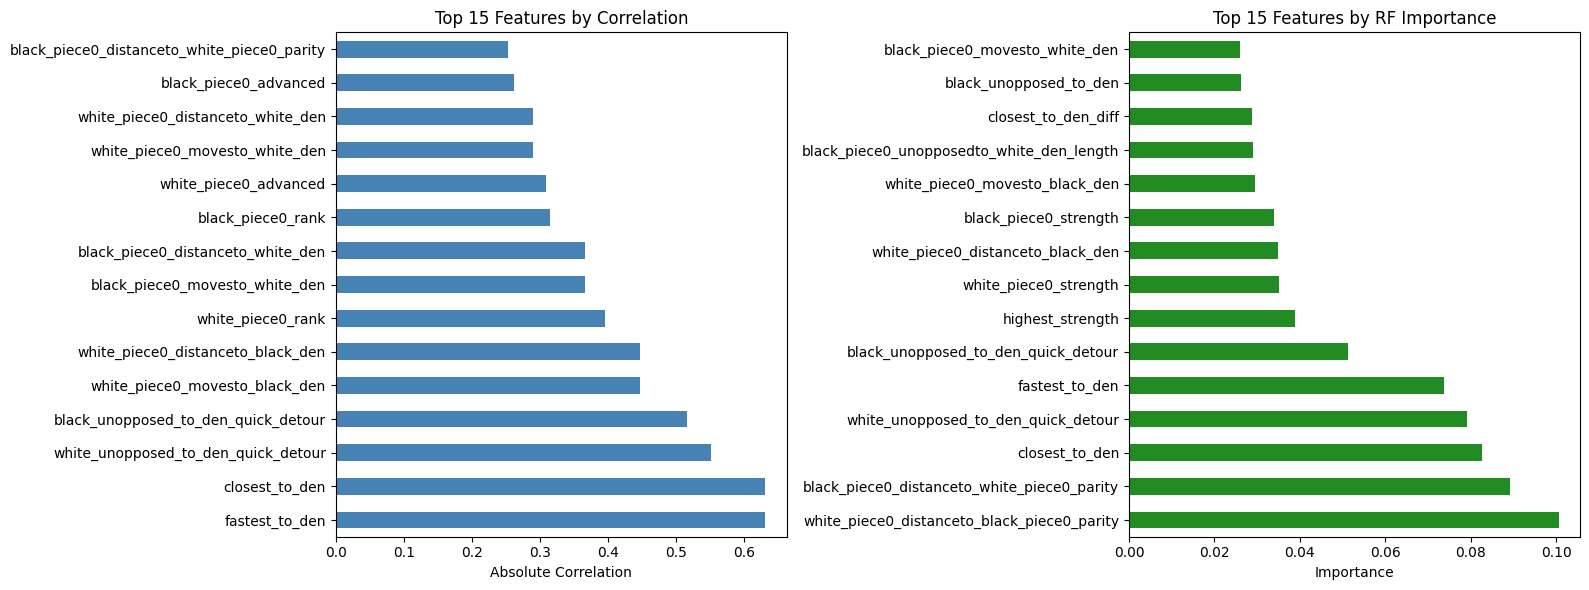

In [136]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

correlations.head(15).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 15 Features by Correlation')
axes[0].set_xlabel('Absolute Correlation')

importances.head(15).plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title('Top 15 Features by RF Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [137]:
# Select top features (union of top 20 from each method)
top_corr_features = set(correlations.head(20).index)
top_rf_features = set(importances.head(20).index)
selected_features = list(top_corr_features.union(top_rf_features))

print(f"\n3. Selected {len(selected_features)} features (union of top 20 from each method)")
print(f"Selected features: {selected_features}")

# Create selected feature datasets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nX_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")


3. Selected 29 features (union of top 20 from each method)
Selected features: ['fastest_to_den_diff', 'white_piece0_in_trap', 'white_piece0_distanceto_white_den', 'black_piece0_in_trap', 'black_piece0_strength', 'white_unopposed_to_den_quick_detour', 'black_piece0_distanceto_black_den', 'black_piece0_rank', 'white_piece0_distanceto_black_den', 'black_piece0_movesto_white_den', 'black_unopposed_to_den', 'highest_strength', 'closest_to_den', 'black_piece0_distanceto_white_den', 'fastest_to_den', 'black_unopposed_to_den_quick_detour', 'black_piece0_distanceto_white_piece0_parity', 'white_piece0_advanced', 'white_piece0_movesto_black_den', 'white_piece0_distanceto_black_piece0_parity', 'white_unopposed_to_den', 'white_piece0_unopposedto_black_den_length', 'black_piece0_advanced', 'closest_to_den_diff', 'white_piece0_movesto_white_den', 'black_piece0_unopposedto_white_den_length', 'white_piece0_rank', 'black_piece0_movesto_black_den', 'white_piece0_strength']

X_train_selected shape: (4704

## Step 2: Imbalance Handling Strategies

We'll create 4 different pipelines using **ImbPipeline**:

| Pipeline | Strategy | Type | Description |
|----------|----------|------|-------------|
| 1 | **None** | Baseline | No resampling |
| 2 | **KMeansSMOTE** | Oversampling | KMeans clustering + SMOTE |
| 3 | **ClusterCentroids** | Undersampling | Cluster-based centroid sampling |
| 4 | **SMOTEENN** | Combined | SMOTE + Edited Nearest Neighbors |

Using `ImbPipeline` from `imblearn.pipeline` for clean, reproducible code.


In [138]:
# Store resampled datasets
resampled_data = {}

In [139]:
# Calculate Sampling Strategy for Multi-Class Resampling
X_np = X_train_selected.values
y_np = y_train.values

# Get original class distribution
unique_classes, class_counts = np.unique(y_np, return_counts=True)
original_dist = dict(zip(unique_classes, class_counts))

# Find majority class
majority_class = max(original_dist, key=original_dist.get)
majority_count = original_dist[majority_class]


# This brings minority from ~13% to ~20-25%
target_minority_ratio = 0.5
target_minority_count = int(majority_count * target_minority_ratio)


# Oversampling strategy: increase minority classes, keep majority unchanged
oversample_strategy = {}
for cls, cnt in original_dist.items():
    if cnt < target_minority_count:
        oversample_strategy[cls] = target_minority_count 
    else:
        oversample_strategy[cls] = cnt 

# Undersampling strategy: reduce majority, keep minority unchanged
undersample_target = int(majority_count * 0.7)
undersample_strategy = {}
for cls, cnt in original_dist.items():
    if cnt == majority_count:
        undersample_strategy[cls] = undersample_target
    else:
        undersample_strategy[cls] = cnt


for cls, cnt in oversample_strategy.items():
    orig = original_dist[cls]
    change = cnt - orig

for cls, cnt in undersample_strategy.items():
    orig = original_dist[cls]
    change = cnt - orig

In [140]:
# Apply Resampling Strategies

# 1. No Resampling (Baseline)
resampled_data['None'] = (X_np.copy(), y_np.copy())

# 2. KMeansSMOTE (Oversampling)
kmeans_smote = KMeansSMOTE(
    sampling_strategy=oversample_strategy,
    random_state=RANDOM_SEED,
    k_neighbors=3,
    cluster_balance_threshold=0.1
)
X_km, y_km = kmeans_smote.fit_resample(X_np, y_np)
resampled_data['KMeansSMOTE'] = (X_km, y_km)


# 3. ClusterCentroids (Undersampling)
cluster_centroids = ClusterCentroids(
    sampling_strategy=undersample_strategy,
    random_state=RANDOM_SEED
)
X_cc, y_cc = cluster_centroids.fit_resample(X_np, y_np)
resampled_data['ClusterCentroids'] = (X_cc, y_cc)


# 4. SMOTEENN (Combined)
smoteenn = SMOTEENN(
    sampling_strategy=oversample_strategy,
    random_state=RANDOM_SEED
)
X_se, y_se = smoteenn.fit_resample(X_np, y_np)
resampled_data['SMOTEENN'] = (X_se, y_se)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (788) found smaller than n_clusters (1753). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (245) found smaller than n_clusters (618). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1059) found smaller than n_clusters (1633). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


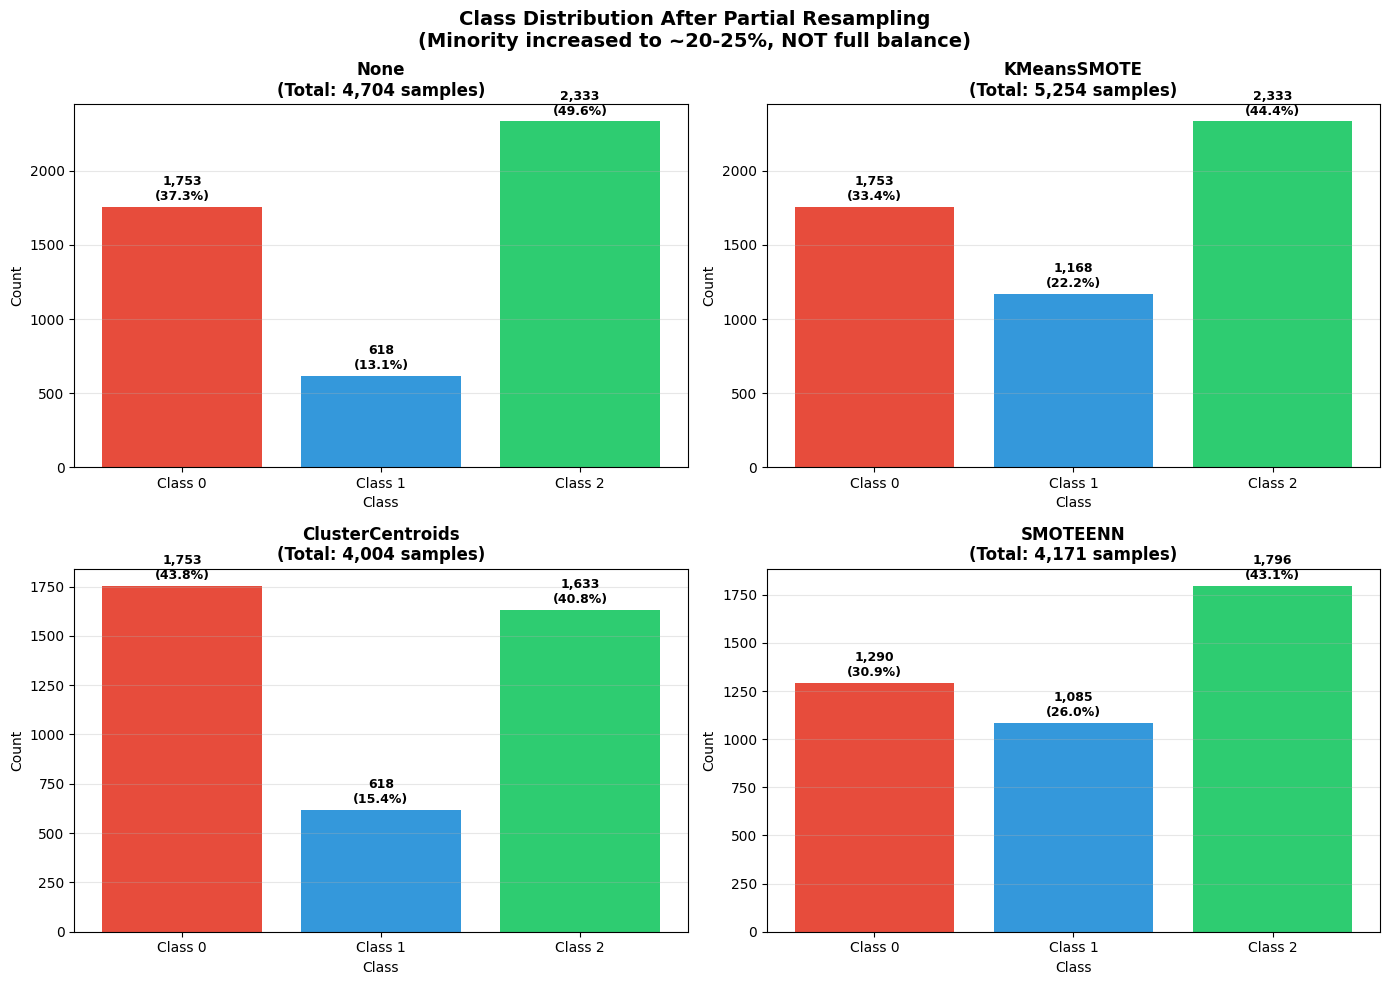

In [141]:
# Visualize Resampling Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, (X_res, y_res)) in enumerate(resampled_data.items()):
    unique, counts = np.unique(y_res, return_counts=True)
    total = sum(counts)
    percentages = [c/total*100 for c in counts]
    
    bars = axes[idx].bar(unique, counts, color=colors[:len(unique)])
    axes[idx].set_title(f'{name}\n(Total: {total:,} samples)', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(unique)
    axes[idx].set_xticklabels([f'Class {c}' for c in unique])
    axes[idx].grid(axis='y', alpha=0.3)
    
    for bar, c, pct in zip(bars, counts, percentages):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.02,
                      f'{c:,}\n({pct:.1f}%)', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Class Distribution After Partial Resampling\n(Minority increased to ~20-25%, NOT full balance)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 3: Define Base Models

7 classification models:
1. Decision Tree
2. Logistic Regression
3. SVM
4. KNN
5. Random Forest
6. Gradient Boosting
7. XGBoost


In [142]:
# Define Base Models
base_models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'LogisticRegression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'SVM': SVC(random_state=RANDOM_SEED, probability=True),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'XGBoost': XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss')
}

## Step 4: Train Base Models on All Resampled Datasets

Train each model on each resampling strategy and log to MLflow.


In [143]:
# Train Models using ImbPipeline and resampled_data

# Store results
results = []
trained_pipelines = {}

# Prepare test data (using selected features)
X_test_np = X_test_selected.values
y_test_np = y_test.values


# Train on each resampled dataset from resampled_data
for resample_name, (X_res, y_res) in resampled_data.items():
    
    # Scale the resampled data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test_np)
    
    for model_name, model in base_models.items():

        model_clone = model.__class__(**model.get_params())     # Clone model
        
        run_name = f"{model_name}_{resample_name}"
        
        mlflow.end_run()  # Close any active run
        with mlflow.start_run(run_name=run_name):
            mlflow.log_param('model', model_name)
            mlflow.log_param('resampling', resample_name)
            mlflow.log_param('n_features', X_res.shape[1])
            mlflow.log_param('n_train_samples', X_res.shape[0])
            
            # Use scaled data for distance-based models
            if model_name in ['SVM', 'LogisticRegression', 'KNN']:
                model_clone.fit(X_train_scaled, y_res)
                y_pred = model_clone.predict(X_test_scaled)
                y_proba = model_clone.predict_proba(X_test_scaled) if hasattr(model_clone, 'predict_proba') else None
            else:
                model_clone.fit(X_res, y_res)
                y_pred = model_clone.predict(X_test_np)
                y_proba = model_clone.predict_proba(X_test_np) if hasattr(model_clone, 'predict_proba') else None
            
            # Calculate metrics
            acc = accuracy_score(y_test_np, y_pred)
            f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
            prec = precision_score(y_test_np, y_pred, average='macro', zero_division=0)
            rec = recall_score(y_test_np, y_pred, average='macro', zero_division=0)
            
            log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
            
            results.append({
                'Model': model_name,
                'Resampling': resample_name,
                'Accuracy': acc,
                'F1_Macro': f1,
                'Precision': prec,
                'Recall': rec,
                'Status': 'SUCCESS'
            })
            
            trained_pipelines[run_name] = model_clone
            print(f"{model_name}: Acc={acc:.4f}, F1={f1:.4f}")
            


results_df = pd.DataFrame(results)
print("\n\ndone")

DecisionTree: Acc=0.9906, F1=0.9848
LogisticRegression: Acc=0.8631, F1=0.7922
SVM: Acc=0.9864, F1=0.9807
KNN: Acc=0.9881, F1=0.9818
RandomForest: Acc=0.9889, F1=0.9834
GradientBoosting: Acc=0.9906, F1=0.9870
XGBoost: Acc=0.9889, F1=0.9834
DecisionTree: Acc=0.9889, F1=0.9834
LogisticRegression: Acc=0.8571, F1=0.8057
SVM: Acc=0.9881, F1=0.9835
KNN: Acc=0.9881, F1=0.9818
RandomForest: Acc=0.9889, F1=0.9834
GradientBoosting: Acc=0.9923, F1=0.9883
XGBoost: Acc=0.9923, F1=0.9875
DecisionTree: Acc=0.9906, F1=0.9863
LogisticRegression: Acc=0.8512, F1=0.7903
SVM: Acc=0.9881, F1=0.9844
KNN: Acc=0.9881, F1=0.9821
RandomForest: Acc=0.9889, F1=0.9834
GradientBoosting: Acc=0.9923, F1=0.9905
XGBoost: Acc=0.9906, F1=0.9862
DecisionTree: Acc=0.9779, F1=0.9697
LogisticRegression: Acc=0.8486, F1=0.8053
SVM: Acc=0.9762, F1=0.9703
KNN: Acc=0.9668, F1=0.9561
RandomForest: Acc=0.9838, F1=0.9774
GradientBoosting: Acc=0.9796, F1=0.9741
XGBoost: Acc=0.9796, F1=0.9715


done


In [144]:
ls mlruns

583555112542638929/


In [145]:
# Results Summary

# Pivot table for better visualization
pivot_acc = results_df.pivot(index='Model', columns='Resampling', values='Accuracy')
pivot_f1 = results_df.pivot(index='Model', columns='Resampling', values='F1_Macro')

print("\nAccuracy by Model and Resampling:")
print(pivot_acc.round(4).to_string())

print("\nF1 Macro by Model and Resampling:")
print(pivot_f1.round(4).to_string())


Accuracy by Model and Resampling:
Resampling          ClusterCentroids  KMeansSMOTE    None  SMOTEENN
Model                                                              
DecisionTree                  0.9906       0.9889  0.9906    0.9779
GradientBoosting              0.9923       0.9923  0.9906    0.9796
KNN                           0.9881       0.9881  0.9881    0.9668
LogisticRegression            0.8512       0.8571  0.8631    0.8486
RandomForest                  0.9889       0.9889  0.9889    0.9838
SVM                           0.9881       0.9881  0.9864    0.9762
XGBoost                       0.9906       0.9923  0.9889    0.9796

F1 Macro by Model and Resampling:
Resampling          ClusterCentroids  KMeansSMOTE    None  SMOTEENN
Model                                                              
DecisionTree                  0.9863       0.9834  0.9848    0.9697
GradientBoosting              0.9905       0.9883  0.9870    0.9741
KNN                           0.9821       0.9

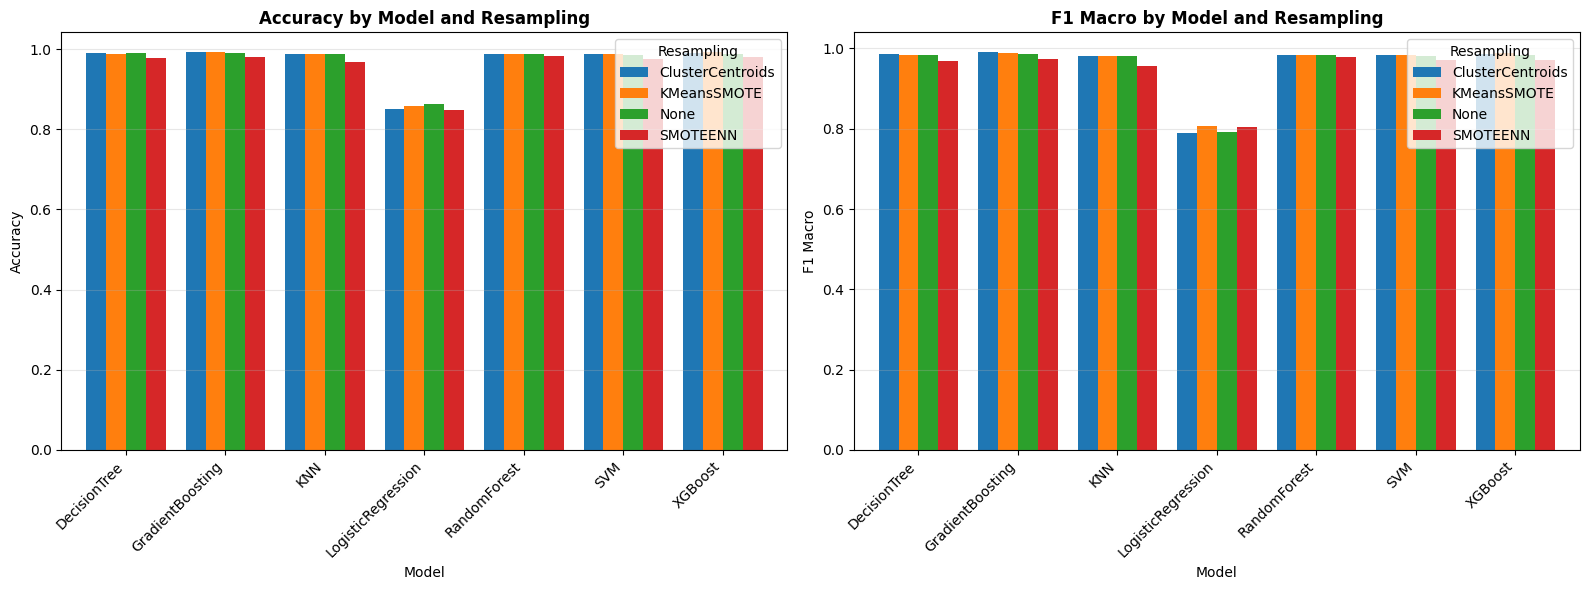

In [146]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pivot_acc.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Accuracy by Model and Resampling', fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].legend(title='Resampling')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

pivot_f1.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('F1 Macro by Model and Resampling', fontweight='bold')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Macro')
axes[1].legend(title='Resampling')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [147]:
# Best model per resampling
print("\nBest Model per Resampling Strategy (by F1):")
for resample in resampled_data.keys():
    best_row = results_df[results_df['Resampling'] == resample].nlargest(1, 'F1_Macro').iloc[0]
    print(f"{resample}: {best_row['Model']} (F1={best_row['F1_Macro']:.4f})")


Best Model per Resampling Strategy (by F1):
None: GradientBoosting (F1=0.9870)
KMeansSMOTE: GradientBoosting (F1=0.9883)
ClusterCentroids: GradientBoosting (F1=0.9905)
SMOTEENN: RandomForest (F1=0.9774)


## Step 5: Ensemble Methods

Create ensembles for each resampling strategy:
1. **VotingClassifier** - Soft voting of top 3 models
2. **StackingClassifier** - Stack with LogisticRegression meta-learner
3. **BaggingClassifier** - Bagging with best base model


In [148]:
# Ensemble Methods using resampled_data

ensemble_results = []

for resample_name, (X_res, y_res) in resampled_data.items():
    
    # Scale data 34an 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test_np)
    
    # 1. VotingClassifier
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)),
            ('xgb', XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss')),
            ('gb', GradientBoostingClassifier(random_state=RANDOM_SEED))
        ],
        voting='soft'
    )
    
    mlflow.end_run()  # Close any active run
    with mlflow.start_run(run_name=f'VotingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'VotingClassifier')
        mlflow.log_param('resampling', resample_name)
        

        voting_clf.fit(X_res, y_res)
        y_pred = voting_clf.predict(X_test_np)
        y_proba = voting_clf.predict_proba(X_test_np)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        ensemble_results.append({'Ensemble': 'VotingClassifier', 'Resampling': resample_name,
                                    'Accuracy': acc, 'F1_Macro': f1})

    
    # 2. StackingClassifier
    stacking_clf = StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50)),
            ('dt', DecisionTreeClassifier(random_state=RANDOM_SEED)),
            ('knn', KNeighborsClassifier())
        ],
        final_estimator=LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
        cv=3
    )
    
    mlflow.end_run()  # Close any active run
    with mlflow.start_run(run_name=f'StackingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'StackingClassifier')
        mlflow.log_param('resampling', resample_name)
        
        stacking_clf.fit(X_train_scaled, y_res)
        y_pred = stacking_clf.predict(X_test_scaled)
        y_proba = stacking_clf.predict_proba(X_test_scaled)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        ensemble_results.append({'Ensemble': 'StackingClassifier', 'Resampling': resample_name,
                                    'Accuracy': acc, 'F1_Macro': f1})

    
    # 3. BaggingClassifier
    bagging_clf = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_SEED),
        n_estimators=50,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    mlflow.end_run()  # Close any active run
    with mlflow.start_run(run_name=f'BaggingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'BaggingClassifier')
        mlflow.log_param('resampling', resample_name)
        
        bagging_clf.fit(X_res, y_res)
        y_pred = bagging_clf.predict(X_test_np)
        y_proba = bagging_clf.predict_proba(X_test_np)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        ensemble_results.append({'Ensemble': 'BaggingClassifier', 'Resampling': resample_name,
                                    'Accuracy': acc, 'F1_Macro': f1})


ensemble_df = pd.DataFrame(ensemble_results)
print("\ndingdong")


dingdong


In [149]:
# Ensemble Results Summary
pivot_ens = ensemble_df.pivot(index='Ensemble', columns='Resampling', values='F1_Macro')
print("\nF1 Macro by Ensemble and Resampling:")
print(pivot_ens.round(4).to_string())


F1 Macro by Ensemble and Resampling:
Resampling          ClusterCentroids  KMeansSMOTE    None  SMOTEENN
Ensemble                                                           
BaggingClassifier             0.9862       0.9834  0.9848    0.9741
StackingClassifier            0.9832       0.9861  0.9861    0.9708
VotingClassifier              0.9862       0.9863  0.9834    0.9774


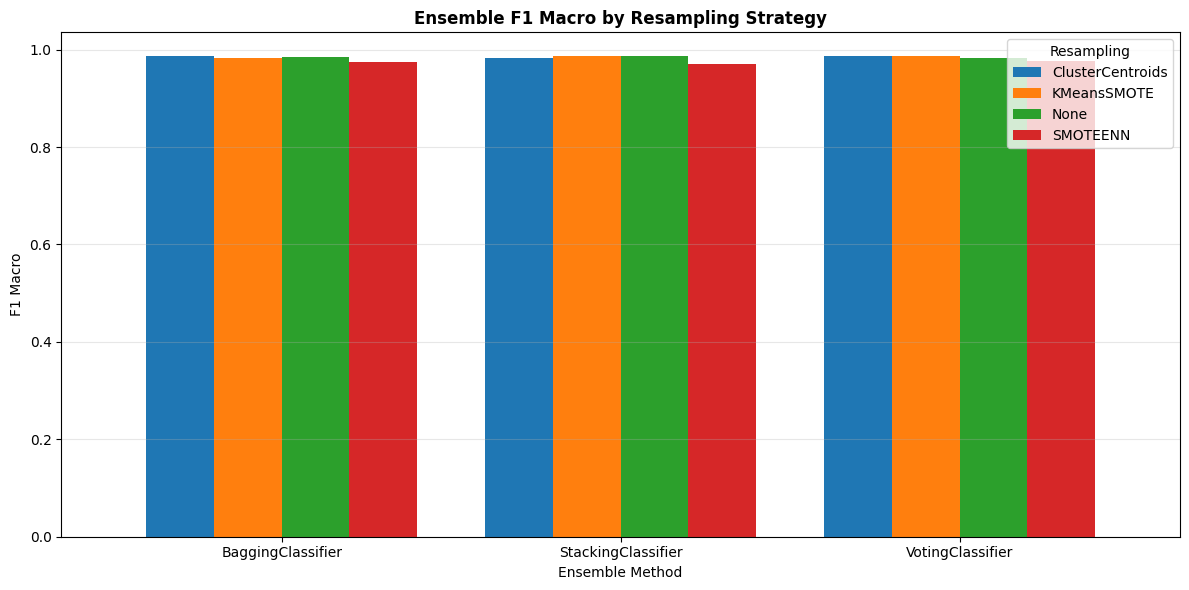

In [150]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
pivot_ens.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Ensemble F1 Macro by Resampling Strategy', fontweight='bold')
ax.set_xlabel('Ensemble Method')
ax.set_ylabel('F1 Macro')
ax.legend(title='Resampling')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [151]:
# Best overall
best_ens = ensemble_df.nlargest(3, 'F1_Macro')
print("\nTop 3 Ensemble Configurations:")
print(best_ens.to_string(index=False))


Top 3 Ensemble Configurations:
         Ensemble       Resampling  Accuracy  F1_Macro
 VotingClassifier      KMeansSMOTE  0.990646  0.986275
 VotingClassifier ClusterCentroids  0.990646  0.986216
BaggingClassifier ClusterCentroids  0.990646  0.986216


## Step 5b: Cost-Sensitive Classification

Instead of resampling, we can handle class imbalance by adjusting class weights.

Approaches:
- class_weight='balanced' - Automatically adjusts weights inversely proportional to class frequencies
- Custom class weights - Manually specify weights based on business cost
- sample_weight - Per-sample weights during training

Advantages over Resampling:
- No synthetic data generation
- No data loss from undersampling
- Faster training (original dataset size)
- Works with any cost structure


In [152]:
# Cost-Sensitive Classification
# Compute balanced weights
classes = np.unique(y_np)
balanced_weights = compute_class_weight('balanced', classes=classes, y=y_np)
class_weight_dict = dict(zip(classes, balanced_weights))

print(f"\nClass distribution: {dict(zip(*np.unique(y_np, return_counts=True)))}")
print(f"Balanced class weights: {class_weight_dict}")

# Custom weights - Class 1 (Draw) is minority, give it higher weight
# Higher weight = higher penalty for misclassification
custom_weights = {
    0: 1.0,  # Black (majority)
    1: 3.0,  # Draw (MINORITY - higher penalty)
    2: 1.0   # White (majority)
}
print(f"Custom class weights (Class 1=Draw is minority): {custom_weights}")

# Models with class_weight support
cost_sensitive_models = {
    'DT_Balanced': DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight='balanced'),
    'DT_Custom': DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight=custom_weights),
    'LR_Balanced': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
    'LR_Custom': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight=custom_weights),
    'SVM_Balanced': SVC(random_state=RANDOM_SEED, probability=True, class_weight='balanced'),
    'SVM_Custom': SVC(random_state=RANDOM_SEED, probability=True, class_weight=custom_weights),
    'RF_Balanced': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, class_weight='balanced'),
    'RF_Custom': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, class_weight=custom_weights),
}


Class distribution: {np.int64(0): np.int64(1753), np.int64(1): np.int64(618), np.int64(2): np.int64(2333)}
Balanced class weights: {np.int64(0): np.float64(0.894466628636623), np.int64(1): np.float64(2.5372168284789645), np.int64(2): np.float64(0.6720960137162452)}
Custom class weights (Class 1=Draw is minority): {0: 1.0, 1: 3.0, 2: 1.0}


In [153]:

cost_sensitive_results = []

# Use original data (no resampling) for cost-sensitive
X_cs, y_cs = resampled_data['None']
scaler = StandardScaler()
X_cs_scaled = scaler.fit_transform(X_cs)
X_test_cs_scaled = scaler.transform(X_test_np)

for model_name, model in cost_sensitive_models.items():
    mlflow.end_run()  # Close any active run
    with mlflow.start_run(run_name=f'CostSensitive_{model_name}'):
        mlflow.log_param('model', model_name)
        mlflow.log_param('approach', 'cost_sensitive')
        mlflow.log_param('resampling', 'None')
        
        # Use scaled for SVM, LR
        if 'SVM' in model_name or 'LR' in model_name:
            model.fit(X_cs_scaled, y_cs)
            y_pred = model.predict(X_test_cs_scaled)
            y_proba = model.predict_proba(X_test_cs_scaled) if hasattr(model, 'predict_proba') else None
        else:
            model.fit(X_cs, y_cs)
            y_pred = model.predict(X_test_np)
            y_proba = model.predict_proba(X_test_np) if hasattr(model, 'predict_proba') else None
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        prec = precision_score(y_test_np, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test_np, y_pred, average='macro', zero_division=0)
        
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        cost_sensitive_results.append({
            'Model': model_name,
            'Approach': 'CostSensitive',
            'Resampling': 'None',
            'Accuracy': acc,
            'F1_Macro': f1,
            'Precision': prec,
            'Recall': rec
        })
        print(f"[DONE] {model_name}: Acc={acc:.4f}, F1={f1:.4f}")
            


cost_sensitive_df = pd.DataFrame(cost_sensitive_results)
print("\n[DONE]")

[DONE] DT_Balanced: Acc=0.9906, F1=0.9864
[DONE] DT_Custom: Acc=0.9906, F1=0.9864
[DONE] LR_Balanced: Acc=0.8546, F1=0.8223
[DONE] LR_Custom: Acc=0.8546, F1=0.8181
[DONE] SVM_Balanced: Acc=0.9813, F1=0.9743
[DONE] SVM_Custom: Acc=0.9855, F1=0.9801
[DONE] RF_Balanced: Acc=0.9906, F1=0.9863
[DONE] RF_Custom: Acc=0.9906, F1=0.9863

[DONE]


In [154]:
# Cost-Sensitive Results Summary
print("\nCost-Sensitive Model Performance:")
print(cost_sensitive_df.sort_values('F1_Macro', ascending=False).to_string(index=False))


Cost-Sensitive Model Performance:
       Model      Approach Resampling  Accuracy  F1_Macro  Precision   Recall
 DT_Balanced CostSensitive       None  0.990646  0.986392   0.985829 0.986966
   DT_Custom CostSensitive       None  0.990646  0.986392   0.985829 0.986966
 RF_Balanced CostSensitive       None  0.990646  0.986275   0.988850 0.983779
   RF_Custom CostSensitive       None  0.990646  0.986275   0.988850 0.983779
  SVM_Custom CostSensitive       None  0.985544  0.980077   0.971542 0.989726
SVM_Balanced CostSensitive       None  0.981293  0.974294   0.963575 0.986872
 LR_Balanced CostSensitive       None  0.854592  0.822307   0.809321 0.864864
   LR_Custom CostSensitive       None  0.854592  0.818089   0.809663 0.859965


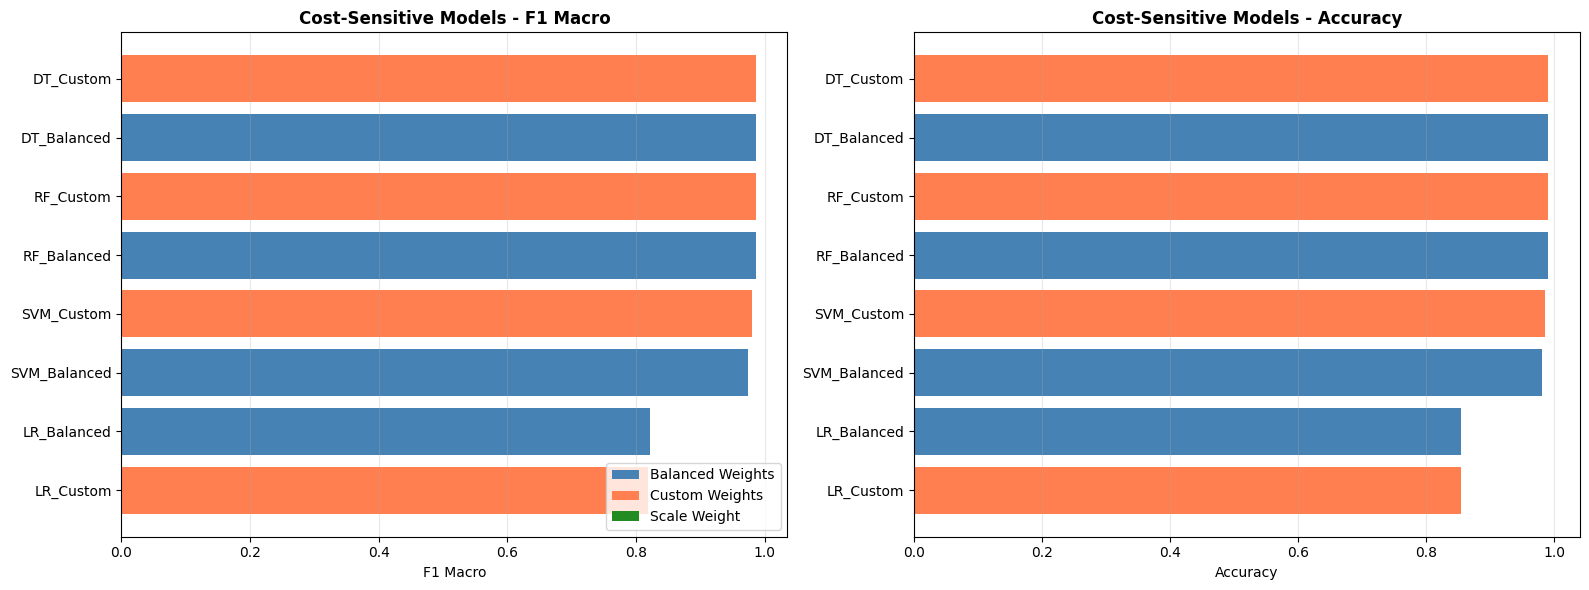

In [155]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort by F1
sorted_df = cost_sensitive_df.sort_values('F1_Macro', ascending=True)

# F1 Macro
colors = ['steelblue' if 'Balanced' in m else 'coral' if 'Custom' in m else 'forestgreen' 
          for m in sorted_df['Model']]
axes[0].barh(sorted_df['Model'], sorted_df['F1_Macro'], color=colors)
axes[0].set_xlabel('F1 Macro')
axes[0].set_title('Cost-Sensitive Models - F1 Macro', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Accuracy
axes[1].barh(sorted_df['Model'], sorted_df['Accuracy'], color=colors)
axes[1].set_xlabel('Accuracy')
axes[1].set_title('Cost-Sensitive Models - Accuracy', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add legend
legend_elements = [
    Patch(facecolor='steelblue', label='Balanced Weights'),
    Patch(facecolor='coral', label='Custom Weights'),
    Patch(facecolor='forestgreen', label='Scale Weight')
]
axes[0].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()



In [156]:
# Compare best cost-sensitive vs best resampling

best_cost_sensitive = cost_sensitive_df.nlargest(1, 'F1_Macro').iloc[0]
best_resampling = results_df[results_df['Status'] == 'SUCCESS'].nlargest(1, 'F1_Macro').iloc[0] if 'Status' in results_df.columns else results_df.nlargest(1, 'F1_Macro').iloc[0]

print(f"\nBest Cost-Sensitive: {best_cost_sensitive['Model']}")
print(f"  F1 Macro: {best_cost_sensitive['F1_Macro']:.4f}")
print(f"  Accuracy: {best_cost_sensitive['Accuracy']:.4f}")

print(f"\nBest Resampling: {best_resampling['Model']} ({best_resampling['Resampling']})")
print(f"  F1 Macro: {best_resampling['F1_Macro']:.4f}")
print(f"  Accuracy: {best_resampling['Accuracy']:.4f}")


Best Cost-Sensitive: DT_Balanced
  F1 Macro: 0.9864
  Accuracy: 0.9906

Best Resampling: GradientBoosting (ClusterCentroids)
  F1 Macro: 0.9905
  Accuracy: 0.9923


Cost-Sensitive Classification Explained

How it Works:
- class_weight='balanced': Automatically computes weights as `n_samples / (n_classes * np.bincount(y))`
- Custom weights: You define the cost of misclassifying each class
- scale_pos_weight (XGBoost): Ratio of negative to positive samples

When to Use:
| Approach | Best For |
|----------|----------|
| Resampling | When you have very few minority samples, need diverse synthetic data |
| Cost-Sensitive | When original data distribution matters, faster training needed |
| Both | Experiment with both and compare results! |

Business Cost Example:
```python
# If misclassifying a Draw (Class 1) is 3x more costly:
custom_weights = {0: 1.0, 1: 3.0, 2: 1.0}
```


## Step 6: Hyperparameter Tuning with StratifiedKFold

Tune the best performing models using RandomizedSearchCV with StratifiedKFold.


In [157]:
# Hyperparameter Tuning - Best from Each Base Classifier and Ensemble

# Define which base classifiers to tune (one best per classifier type)
base_classifier_names = ['DecisionTree', 'LogisticReg', 'SVM', 'KNN', 'RandomForest', 'GradientBoosting', 'XGBoost']
ensemble_names = ['VotingClassifier', 'StackingClassifier', 'BaggingClassifier']

# Combine all results so far
all_base_results = pd.concat([
    results_df[results_df['Status'] == 'SUCCESS'][['Model', 'Resampling', 'Accuracy', 'F1_Macro']].assign(Type='BaseModel'),
    ensemble_df[['Ensemble', 'Resampling', 'Accuracy', 'F1_Macro']].rename(columns={'Ensemble': 'Model'}).assign(Type='Ensemble'),
    cost_sensitive_df[['Model', 'Resampling', 'Accuracy', 'F1_Macro']].assign(Type='CostSensitive')
], ignore_index=True)

In [158]:
# Select best model from each base classifier type
models_to_tune = []
for clf_name in base_classifier_names:
    mask = all_base_results['Model'].str.contains(clf_name, case=False, na=False)
    subset = all_base_results[mask]
    if len(subset) > 0:
        best = subset.nlargest(1, 'F1_Macro').iloc[0]
        models_to_tune.append(best)

# Select best from each ensemble type
for ens_name in ensemble_names:
    mask = all_base_results['Model'].str.contains(ens_name, case=False, na=False)
    subset = all_base_results[mask]
    if len(subset) > 0:
        best = subset.nlargest(1, 'F1_Macro').iloc[0]
        models_to_tune.append(best)

top10 = pd.DataFrame(models_to_tune)
print("\nBest Model per Classifier/Ensemble Type to Tune:")
print(top10[['Model', 'Resampling', 'Type', 'F1_Macro']].to_string(index=False))


Best Model per Classifier/Ensemble Type to Tune:
             Model       Resampling      Type  F1_Macro
      DecisionTree ClusterCentroids BaseModel  0.986275
LogisticRegression      KMeansSMOTE BaseModel  0.805744
               SVM ClusterCentroids BaseModel  0.984406
               KNN ClusterCentroids BaseModel  0.982077
      RandomForest      KMeansSMOTE BaseModel  0.983448
  GradientBoosting ClusterCentroids BaseModel  0.990545
           XGBoost      KMeansSMOTE BaseModel  0.987541
  VotingClassifier      KMeansSMOTE  Ensemble  0.986275
StackingClassifier             None  Ensemble  0.986094
 BaggingClassifier ClusterCentroids  Ensemble  0.986216


In [159]:

# Parameter grids for different model types
param_grids = {
    'DecisionTree': {'max_depth': [5, 10, 15, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'DT': {'max_depth': [5, 10, 15, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'LogisticReg': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']},
    'LR': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']},
    'SVM': {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto', 0.01, 0.1], 'class_weight': ['balanced', None]},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5]},
    'RF': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'VotingClassifier': {},  # Skip tuning for voting
    'StackingClassifier': {},  # Skip tuning for stacking
    'BaggingClassifier': {'n_estimators': [30, 50, 100]}
}

# Model constructors
model_constructors = {
    'DecisionTree': lambda: DecisionTreeClassifier(random_state=RANDOM_SEED),
    'DT': lambda: DecisionTreeClassifier(random_state=RANDOM_SEED),
    'LogisticReg': lambda: LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'LR': lambda: LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'SVM': lambda: SVC(random_state=RANDOM_SEED, probability=True, decision_function_shape='ovr'),
    'KNN': lambda: KNeighborsClassifier(),
    'RandomForest': lambda: RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    'RF': lambda: RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    'GradientBoosting': lambda: GradientBoostingClassifier(random_state=RANDOM_SEED),
    'XGBoost': lambda: XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss'),
    'BaggingClassifier': lambda: BaggingClassifier(random_state=RANDOM_SEED, n_jobs=-1)
}

In [160]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

tuning_results = []
tuned_models = {}

for idx, row in top10.iterrows():
    model_name = row['Model']
    resample_name = row['Resampling']
    model_type = row['Type']
    
    # Find base model name (without _Balanced, _Custom suffix)
    base_name = model_name.split('_')[0] if '_' in model_name else model_name
    
    # Skip if no param grid or constructor
    if base_name not in param_grids or base_name not in model_constructors:
        continue
    
    if not param_grids[base_name]:
        continue
    
    print(f"\nTuning {model_name} ({resample_name}) bruh")
    
    # Get data for this resampling strategy
    X_tune, y_tune = resampled_data.get(resample_name, resampled_data['None'])
    
    # Create model
    model = model_constructors[base_name]()
    
    # Add class_weight for cost-sensitive models
    if 'Balanced' in model_name and hasattr(model, 'class_weight'):
        model.set_params(class_weight='balanced')
    elif 'Custom' in model_name and hasattr(model, 'class_weight'):
        model.set_params(class_weight={0: 1.0, 1: 3.0, 2: 1.0})
    
    # RandomizedSearchCV
    search = RandomizedSearchCV(
        model,
        param_grids[base_name],
        n_iter=min(20, len(param_grids[base_name]) * 3),
        cv=skf,
        scoring='f1_macro',
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    # Scale if needed
    if base_name in ['SVM', 'LogisticReg', 'LR', 'KNN']:
        scaler = StandardScaler()
        X_tune_use = scaler.fit_transform(X_tune)
        X_test_use = scaler.transform(X_test_np)
    else:
        X_tune_use = X_tune
        X_test_use = X_test_np
    
    mlflow.end_run()  # Close any active run
    with mlflow.start_run(run_name=f'Tuned_{model_name}_{resample_name}'):
        search.fit(X_tune_use, y_tune)
        
        mlflow.log_params(search.best_params_)
        mlflow.log_param('model', model_name)
        mlflow.log_param('resampling', resample_name)
        mlflow.log_param('type', 'Tuned')
        mlflow.log_metric('cv_best_f1', search.best_score_)
        
        # Test evaluation
        y_pred = search.best_estimator_.predict(X_test_use)
        y_proba = search.best_estimator_.predict_proba(X_test_use) if hasattr(search.best_estimator_, 'predict_proba') else None
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        tuned_models[f'{model_name}_{resample_name}'] = search.best_estimator_
        tuning_results.append({
            'Model': model_name,
            'Resampling': resample_name,
            'Type': 'Tuned',
            'CV_F1': search.best_score_,
            'Test_Accuracy': acc,
            'Test_F1': f1,
            'Best_Params': str(search.best_params_)
        })
        
        print(f"CV F1: {search.best_score_:.4f} -> Test F1: {f1:.4f}")
        print(f"Best: {search.best_params_}")


tuning_df = pd.DataFrame(tuning_results)
print(f"Tuning {len(tuning_results)} models tuned.")


Tuning DecisionTree (ClusterCentroids) bruh
CV F1: 0.9842 -> Test F1: 0.9878
Best: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}

Tuning SVM (ClusterCentroids) bruh
CV F1: 0.9907 -> Test F1: 0.9946
Best: {'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 100}

Tuning KNN (ClusterCentroids) bruh
CV F1: 0.9821 -> Test F1: 0.9876
Best: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}

Tuning RandomForest (KMeansSMOTE) bruh
CV F1: 0.9909 -> Test F1: 0.9834
Best: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15}

Tuning GradientBoosting (ClusterCentroids) bruh
CV F1: 0.9862 -> Test F1: 0.9834
Best: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

Tuning XGBoost (KMeansSMOTE) bruh
CV F1: 0.9924 -> Test F1: 0.9875
Best: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

Tuning BaggingClassifier (ClusterCentroids) bruh
CV F1: 0.9857 -> Test F1: 0.9862
Best: {'n_estimators': 50}
Tuning 7 models tuned.


## Step 7: Learning Curves & Bias-Variance Analysis

Visualize how models perform with different training sizes.

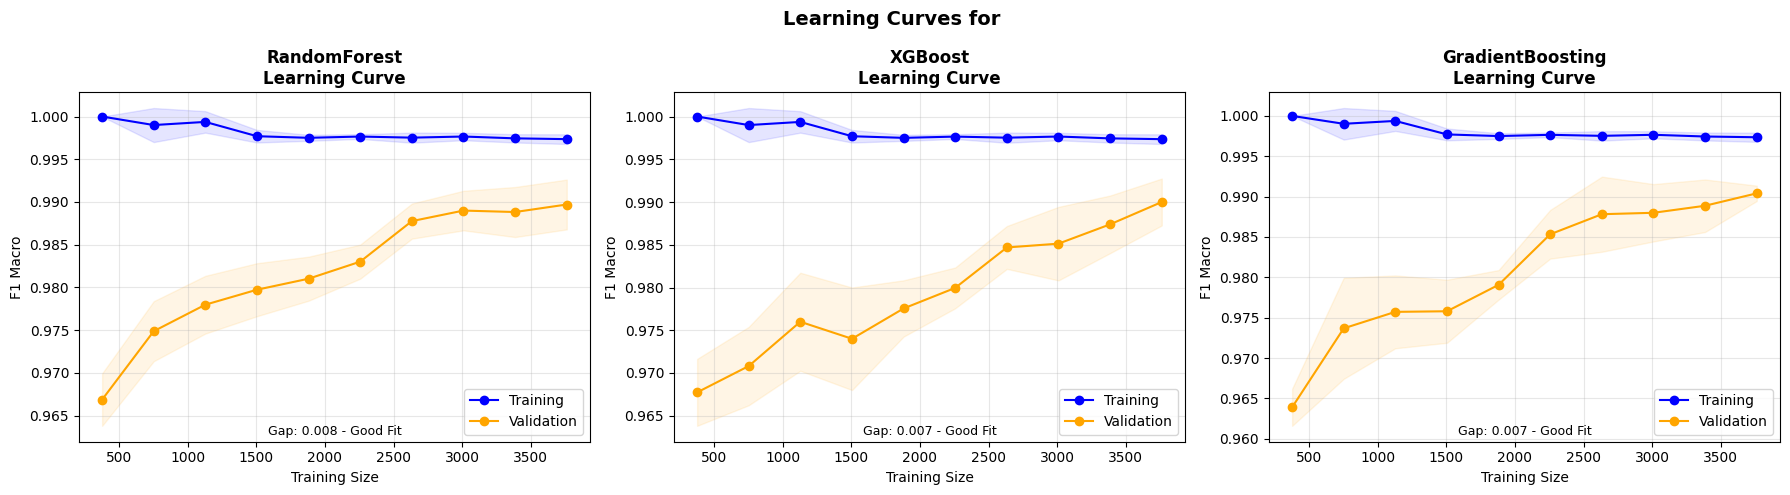


[DONE]


In [161]:
# Learning Curves
X_learning, y_learning = resampled_data.get('None', (X_train_selected, y_train))

models_to_plot = {
    'RandomForest': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss'),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED)
}

# Use tuned models
for key in tuned_models:
    if 'RandomForest' in key:
        models_to_plot['RandomForest'] = tuned_models[key]
    elif 'XGBoost' in key:
        models_to_plot['XGBoost'] = tuned_models[key]
    elif 'GradientBoosting' in key:
        models_to_plot['GradientBoosting'] = tuned_models[key]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(models_to_plot.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_learning, y_learning,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    axes[idx].plot(train_sizes, train_mean, 'o-', label='Training', color='blue')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    axes[idx].plot(train_sizes, val_mean, 'o-', label='Validation', color='orange')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    
    axes[idx].set_title(f'{name}\nLearning Curve', fontweight='bold')
    axes[idx].set_xlabel('Training Size')
    axes[idx].set_ylabel('F1 Macro')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    
    # Bias-Variance analysis
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.1:
        diagnosis = 'High Variance (Overfitting)'
    elif val_mean[-1] < 0.7:
        diagnosis = 'High Bias (Underfitting)'
    else:
        diagnosis = 'Good Fit'
    axes[idx].text(0.5, 0.02, f'Gap: {gap:.3f} - {diagnosis}', 
                   transform=axes[idx].transAxes, fontsize=9, ha='center')

plt.suptitle('Learning Curves for ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=100)
plt.show()

# Log learning curves to MLflow
mlflow.end_run()  # End any active run first
with mlflow.start_run(run_name='Learning_Curves'):
    mlflow.log_param('models_plotted', list(models_to_plot.keys()))
    mlflow.log_artifact('learning_curves.png')

print("\n[DONE]")

## Step 8: Final Model Evaluation

Select the best model and do comprehensive evaluation.



Best Model: SVM
Best Params: {'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 100}

Classification Report:
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00       438
       White       0.97      1.00      0.99       154
        Draw       1.00      0.99      1.00       584

    accuracy                           1.00      1176
   macro avg       0.99      1.00      0.99      1176
weighted avg       1.00      1.00      1.00      1176



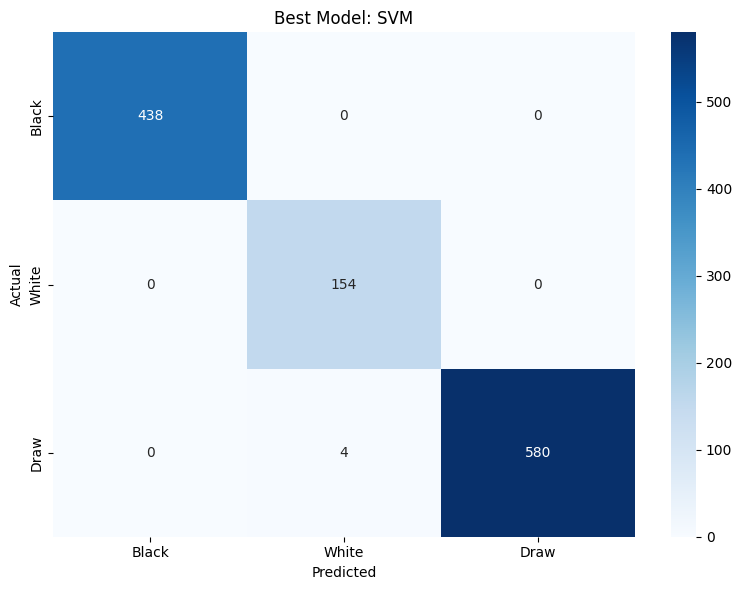

2025/12/20 16:51:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



[DONE]!


In [162]:
# Final Model Evaluation
# Find best model from tuning
best_idx = tuning_df['Test_F1'].idxmax()
best_model_name = tuning_df.loc[best_idx, 'Model']
best_resampling = tuning_df.loc[best_idx, 'Resampling']
best_model_key = f'{best_model_name}_{best_resampling}'
best_model = tuned_models.get(best_model_key)

print(f"\nBest Model: {best_model_name}")
print(f"Best Params: {tuning_df.loc[best_idx, 'Best_Params']}")

# Get proper test data (scaled if needed)
base_name = best_model_name.split('_')[0] if '_' in best_model_name else best_model_name
if base_name in ['SVM', 'LogisticReg', 'LR', 'KNN']:
    scaler = StandardScaler()
    X_train_for_scale, _ = resampled_data.get(best_resampling, resampled_data['None'])
    scaler.fit(X_train_for_scale)
    X_test_final = scaler.transform(X_test_np)
else:
    X_test_final = X_test_np

# Final predictions
y_pred_final = best_model.predict(X_test_final)
y_proba_final = best_model.predict_proba(X_test_final) if hasattr(best_model, 'predict_proba') else None

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_final, target_names=['Black', 'White', 'Draw'], zero_division=0))

# Confusion Matrix
log_confusion_matrix_plot(y_test_np, y_pred_final, title=f'Best Model: {best_model_name}')

# Log final model to MLflow
mlflow.end_run()  # End any active run first
with mlflow.start_run(run_name=f'BEST_{best_model_name}'):
    mlflow.log_param('model', best_model_name)
    mlflow.log_param('type', 'BEST_MODEL')
    log_metrics_to_mlflow(y_test_np, y_pred_final, y_proba_final, prefix='final_')
    mlflow.sklearn.log_model(best_model, 'best_model')
    
print("\n[DONE]!")

In [163]:
# Build Unified Results DataFrame
all_results = []

# Add base classifier results
for _, row in results_df[results_df['Status'] == 'SUCCESS'].iterrows():
    all_results.append({'Model': row['Model'], 'Type': 'BaseClassifier', 'Resampling': row['Resampling'],
        'Accuracy': row['Accuracy'], 'F1_Macro': row['F1_Macro'], 'Precision': row.get('Precision', np.nan), 'Recall': row.get('Recall', np.nan)})

# Add ensemble results
for _, row in ensemble_df.iterrows():
    all_results.append({'Model': row['Ensemble'], 'Type': 'Ensemble', 'Resampling': row['Resampling'],
        'Accuracy': row['Accuracy'], 'F1_Macro': row['F1_Macro'], 'Precision': np.nan, 'Recall': np.nan})

# Add cost-sensitive results
for _, row in cost_sensitive_df.iterrows():
    all_results.append({'Model': row['Model'], 'Type': 'CostSensitive', 'Resampling': 'None',
        'Accuracy': row['Accuracy'], 'F1_Macro': row['F1_Macro'], 'Precision': row.get('Precision', np.nan), 'Recall': row.get('Recall', np.nan)})

# Add tuned results
for _, row in tuning_df.iterrows():
    all_results.append({'Model': row['Model'] + '_Tuned', 'Type': 'Tuned', 'Resampling': row['Resampling'],
        'Accuracy': row['Test_Accuracy'], 'F1_Macro': row['Test_F1'], 'Precision': np.nan, 'Recall': np.nan})

united_nations = pd.DataFrame(all_results)
united_nations.head(10)

,Model,Type,Resampling,Accuracy,F1_Macro,Precision,Recall
0,DecisionTree,BaseClassifier,None,0.990646,0.984773,0.988761,0.980972
1,LogisticRegression,BaseClassifier,None,0.863095,0.792177,0.798206,0.787103
2,SVM,BaseClassifier,None,0.986395,0.980675,0.983926,0.977547
3,KNN,BaseClassifier,None,0.988095,0.981752,0.989777,0.974478
4,RandomForest,BaseClassifier,None,0.988946,0.983374,0.989282,0.977856
5,GradientBoosting,BaseClassifier,None,0.990646,0.987014,0.988894,0.985182
6,XGBoost,BaseClassifier,None,0.988946,0.983374,0.989282,0.977856
7,DecisionTree,BaseClassifier,KMeansSMOTE,0.988946,0.983448,0.987648,0.979450
8,LogisticRegression,BaseClassifier,KMeansSMOTE,0.857143,0.805744,0.799546,0.822143
9,SVM,BaseClassifier,KMeansSMOTE,0.988095,0.983501,0.985160,0.981876


In [164]:
# Display full unified dataframe sorted by F1_Macro
united_nations.sort_values('F1_Macro', ascending=False)

,Model,Type,Resampling,Accuracy,F1_Macro,Precision,Recall
49,SVM_Tuned,Tuned,ClusterCentroids,0.996599,0.994581,NaN,NaN
19,GradientBoosting,BaseClassifier,ClusterCentroids,0.992347,0.990545,0.988456,0.992699
12,GradientBoosting,BaseClassifier,KMeansSMOTE,0.992347,0.988339,0.989813,0.986894
48,DecisionTree_Tuned,Tuned,ClusterCentroids,0.991497,0.987831,NaN,NaN
50,KNN_Tuned,Tuned,ClusterCentroids,0.992347,0.987602,NaN,NaN
53,XGBoost_Tuned,Tuned,KMeansSMOTE,0.992347,0.987541,NaN,NaN
13,XGBoost,BaseClassifier,KMeansSMOTE,0.992347,0.987541,0.991564,0.983707
5,GradientBoosting,BaseClassifier,None,0.990646,0.987014,0.988894,0.985182
41,DT_Custom,CostSensitive,None,0.990646,0.986392,0.985829,0.986966
40,DT_Balanced,CostSensitive,None,0.990646,0.986392,0.985829,0.986966


## Step 9: Model Comparisons via Queries

Using the unified results dataframe to answer comparison questions.

In [165]:
# Query 1: All Base Classifiers Compared
base_clf_query = united_nations[united_nations['Type'] == 'BaseClassifier'].copy()
best_per_base = base_clf_query.loc[base_clf_query.groupby('Model')['F1_Macro'].idxmax()]
best_per_base = best_per_base.sort_values('F1_Macro', ascending=False).reset_index(drop=True)
best_per_base[['Model', 'Resampling', 'Accuracy', 'F1_Macro', 'Precision', 'Recall']]

,Model,Resampling,Accuracy,F1_Macro,Precision,Recall
0,GradientBoosting,ClusterCentroids,0.992347,0.990545,0.988456,0.992699
1,XGBoost,KMeansSMOTE,0.992347,0.987541,0.991564,0.983707
2,DecisionTree,ClusterCentroids,0.990646,0.986275,0.988850,0.983779
3,SVM,ClusterCentroids,0.988095,0.984406,0.980739,0.988251
4,RandomForest,KMeansSMOTE,0.988946,0.983448,0.987648,0.979450
5,KNN,ClusterCentroids,0.988095,0.982077,0.983337,0.980853
6,LogisticRegression,KMeansSMOTE,0.857143,0.805744,0.799546,0.822143


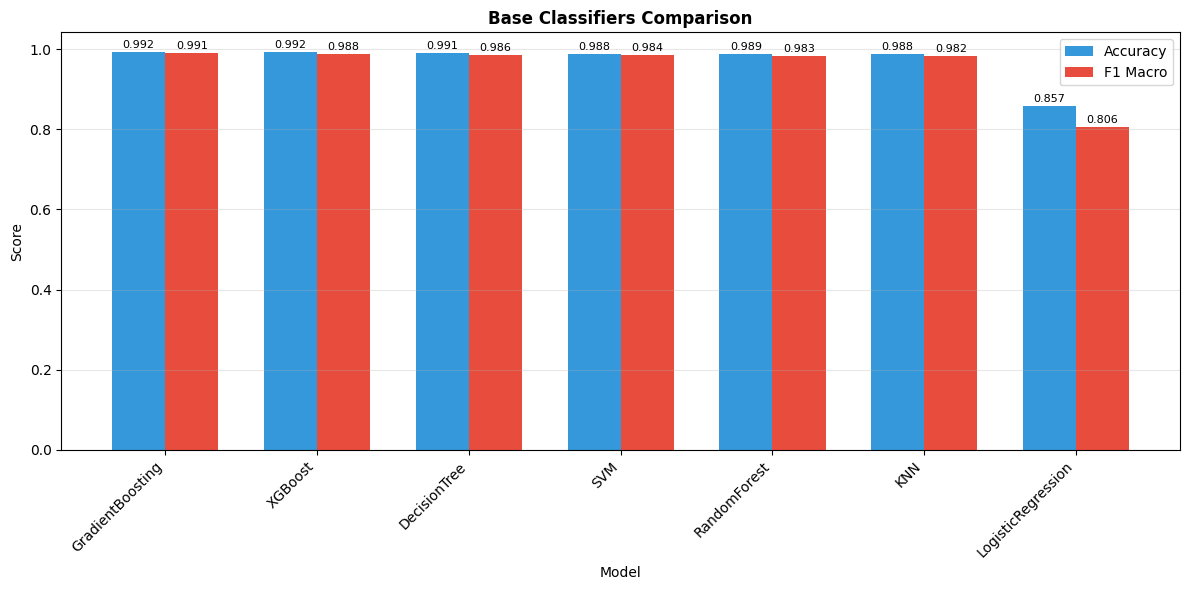

In [166]:
# Visualization: Base Classifiers
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(best_per_base))
width = 0.35
bars1 = ax.bar(x - width/2, best_per_base['Accuracy'], width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, best_per_base['F1_Macro'], width, label='F1 Macro', color='#e74c3c')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Base Classifiers Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(best_per_base['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}', ha='center', fontsize=8)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}', ha='center', fontsize=8)
plt.tight_layout()
plt.savefig('base_classifiers_comparison.png', dpi=100)
plt.show()

In [167]:
# Query 2: All Ensembles Compared
ensemble_query = united_nations[united_nations['Type'] == 'Ensemble'].copy()

best_per_ensemble = ensemble_query.loc[ensemble_query.groupby('Model')['F1_Macro'].idxmax()]
best_per_ensemble = best_per_ensemble.sort_values('F1_Macro', ascending=False).reset_index(drop=True)


best_per_ensemble[['Model', 'Resampling', 'Accuracy', 'F1_Macro']]

,Model,Resampling,Accuracy,F1_Macro
0,VotingClassifier,KMeansSMOTE,0.990646,0.986275
1,BaggingClassifier,ClusterCentroids,0.990646,0.986216
2,StackingClassifier,None,0.990646,0.986094


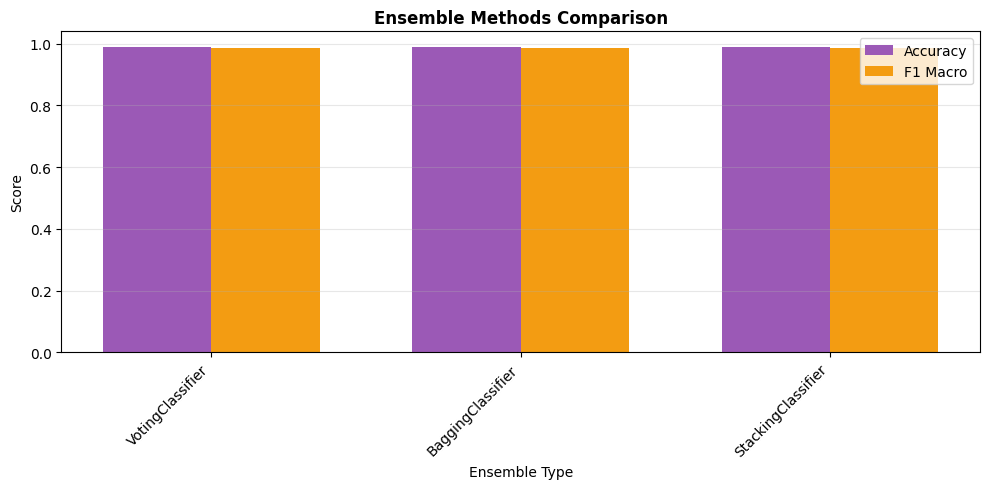

In [168]:
# Visualization: Ensemble Methods
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(best_per_ensemble))
width = 0.35
bars1 = ax.bar(x - width/2, best_per_ensemble['Accuracy'], width, label='Accuracy', color='#9b59b6')
bars2 = ax.bar(x + width/2, best_per_ensemble['F1_Macro'], width, label='F1 Macro', color='#f39c12')
ax.set_xlabel('Ensemble Type')
ax.set_ylabel('Score')
ax.set_title('Ensemble Methods Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(best_per_ensemble['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('ensemble_comparison.png', dpi=100)
plt.show()

In [169]:
# Query 3: Best Resampled vs Best No Resampling
no_resample_query = united_nations[united_nations['Resampling'] == 'None']
best_no_resample = no_resample_query.nlargest(1, 'F1_Macro').iloc[0] if len(no_resample_query) > 0 else None
with_resample_query = united_nations[united_nations['Resampling'] != 'None']
best_with_resample = with_resample_query.nlargest(1, 'F1_Macro').iloc[0] if len(with_resample_query) > 0 else None

resample_compare = []
resample_compare.append({'Strategy': 'No Resampling', 'Model': best_no_resample['Model'], 'Type': best_no_resample['Type'], 'Accuracy': best_no_resample['Accuracy'], 'F1_Macro': best_no_resample['F1_Macro']})
resample_compare.append({'Strategy': f"With Resampling ({best_with_resample['Resampling']})", 'Model': best_with_resample['Model'], 'Type': best_with_resample['Type'], 'Accuracy': best_with_resample['Accuracy'], 'F1_Macro': best_with_resample['F1_Macro']})

resample_compare_df = pd.DataFrame(resample_compare)

# Add improvement row
improvement = best_with_resample['F1_Macro'] - best_no_resample['F1_Macro']
improvement_pct = improvement / best_no_resample['F1_Macro'] * 100
resample_compare_df['F1_Improvement'] = ['baseline', f'{improvement:+.4f} ({improvement_pct:+.2f}%)']

resample_compare_df

,Strategy,Model,Type,Accuracy,F1_Macro,F1_Improvement
0,No Resampling,GradientBoosting,BaseClassifier,0.990646,0.987014,baseline
1,With Resampling (ClusterCentroids),SVM_Tuned,Tuned,0.996599,0.994581,+0.0076 (+0.77%)


In [170]:
# Query 4: Best Model per Resampling Technique
technique_query = united_nations.loc[united_nations.groupby('Resampling')['F1_Macro'].idxmax()]
technique_query = technique_query.sort_values('F1_Macro', ascending=False).reset_index(drop=True)
technique_query[['Resampling', 'Model', 'Type', 'Accuracy', 'F1_Macro']]

,Resampling,Model,Type,Accuracy,F1_Macro
0,ClusterCentroids,SVM_Tuned,Tuned,0.996599,0.994581
1,KMeansSMOTE,GradientBoosting,BaseClassifier,0.992347,0.988339
2,None,GradientBoosting,BaseClassifier,0.990646,0.987014
3,SMOTEENN,VotingClassifier,Ensemble,0.982993,0.977442


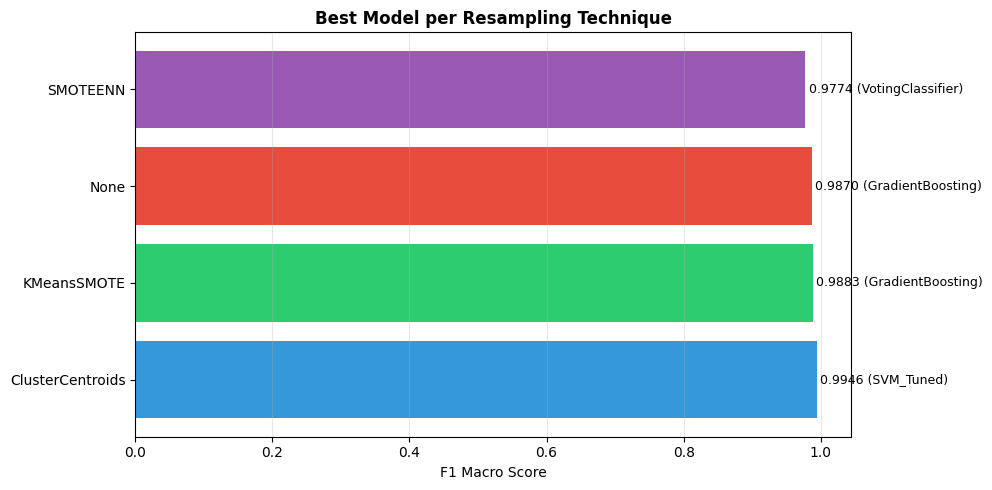

In [171]:
# Visualization: Resampling Techniques
fig, ax = plt.subplots(figsize=(10, 5))
colors_tech = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = ax.barh(technique_query['Resampling'], technique_query['F1_Macro'], color=colors_tech[:len(technique_query)])
ax.set_xlabel('F1 Macro Score')
ax.set_title('Best Model per Resampling Technique', fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for bar, model in zip(bars, technique_query['Model']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f} ({model})', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('resampling_techniques_comparison.png', dpi=100)
plt.show()

In [172]:
# Query 5: Best Single Classifier vs Ensemble vs Cost-Sensitive vs Tuned
best_per_type = united_nations.loc[united_nations.groupby('Type')['F1_Macro'].idxmax()]
best_per_type = best_per_type.sort_values('F1_Macro', ascending=False).reset_index(drop=True)
best_per_type[['Type', 'Model', 'Resampling', 'Accuracy', 'F1_Macro']]

,Type,Model,Resampling,Accuracy,F1_Macro
0,Tuned,SVM_Tuned,ClusterCentroids,0.996599,0.994581
1,BaseClassifier,GradientBoosting,ClusterCentroids,0.992347,0.990545
2,CostSensitive,DT_Balanced,None,0.990646,0.986392
3,Ensemble,VotingClassifier,KMeansSMOTE,0.990646,0.986275


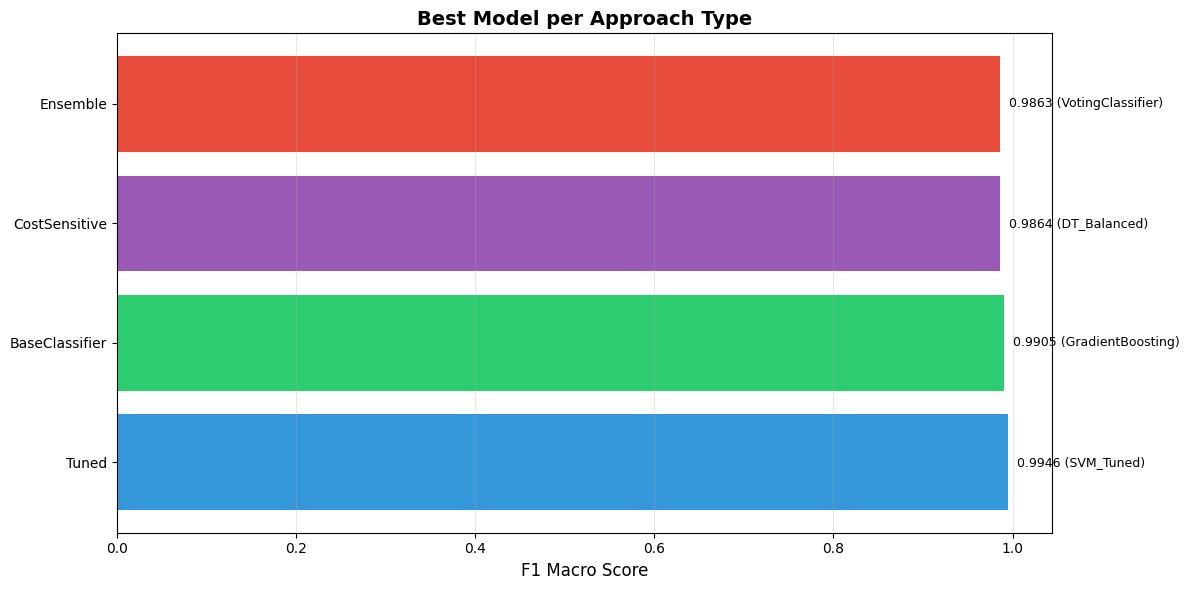

In [173]:
# Visualization: Best per Type
fig, ax = plt.subplots(figsize=(12, 6))
colors_type = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#f39c12']
bars = ax.barh(best_per_type['Type'], best_per_type['F1_Macro'], color=colors_type[:len(best_per_type)])
ax.set_xlabel('F1 Macro Score', fontsize=12)
ax.set_title('Best Model per Approach Type', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for bar, row in zip(bars, best_per_type.itertuples()):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{row.F1_Macro:.4f} ({row.Model})', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('best_per_type_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

In [174]:
# Query 6: Top 3 Models Overall
top3 = united_nations.nlargest(3, 'F1_Macro').reset_index(drop=True)
top3.index = top3.index + 1
top3.index.name = 'Rank'
top3[['Model', 'Type', 'Resampling', 'Accuracy', 'F1_Macro']]

,Model,Type,Resampling,Accuracy,F1_Macro
Rank,,,,,
1,SVM_Tuned,Tuned,ClusterCentroids,0.996599,0.994581
2,GradientBoosting,BaseClassifier,ClusterCentroids,0.992347,0.990545
3,GradientBoosting,BaseClassifier,KMeansSMOTE,0.992347,0.988339


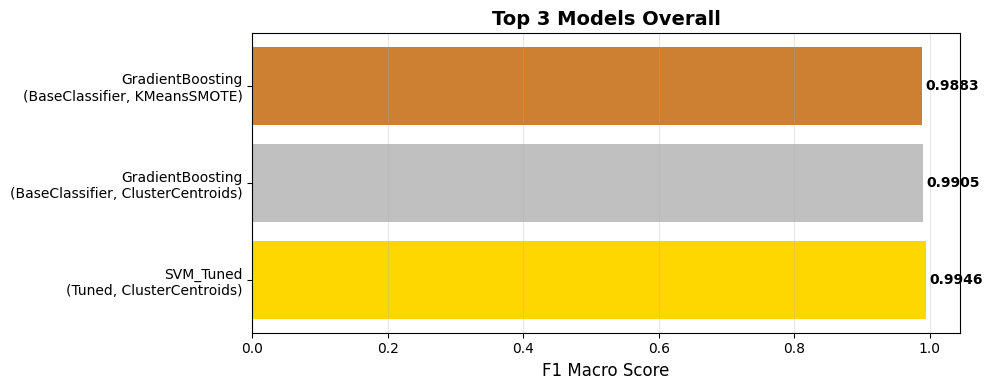

In [175]:
# Visualization: Top 3 Models
fig, ax = plt.subplots(figsize=(10, 4))
colors_top3 = ['#FFD700', '#C0C0C0', '#CD7F32']

labels = [f"{row['Model']}\n({row['Type']}, {row['Resampling']})" for _, row in top3.iterrows()]
bars = ax.barh(labels, top3['F1_Macro'], color=colors_top3)
ax.set_xlabel('F1 Macro Score', fontsize=12)
ax.set_title('Top 3 Models Overall', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for bar in bars:
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('top3_models.png', dpi=100, bbox_inches='tight')
plt.show()

## Step 10: Confusion Matrices for Top Models

Visualize confusion matrices for top 3 models and best from each approach type.

In [176]:
# Build model name to predictions mapping from trained models
def get_model_predictions(model_info, tuned_models, X_test, y_test):
    """Get predictions for a model from available model dictionaries"""
    model_name = model_info['Model'].replace('_Tuned', '')
    model_type = model_info.get('Type', '')
    resampling = model_info.get('Resampling', 'None')
    
    # Base name for scaling check
    base_name = model_name.split('_')[0] if '_' in model_name else model_name
    
    # Check if scaling is needed
    needs_scaling = base_name in ['SVM', 'LogisticReg', 'LR', 'KNN', 'Logistic']
    
    # Prepare test data with scaling if needed
    if needs_scaling:
        scaler = StandardScaler()
        X_train_for_scale, _ = resampled_data.get(resampling, resampled_data['None'])
        scaler.fit(X_train_for_scale)
        X_test_use = scaler.transform(X_test)
    else:
        X_test_use = X_test
    
    # Try to find in tuned_models
    key = f'{model_name}_{resampling}'
    if key in tuned_models:
        model = tuned_models[key]
        return model.predict(X_test_use)
    
    # Try trained_pipelines for base classifiers
    if 'trained_pipelines' in globals():
        for k, m in trained_pipelines.items():
            if model_name in k and resampling in k:
                try:
                    return m.predict(X_test_use)
                except:
                    pass
    
    # Try alternative keys in tuned_models
    for k, m in tuned_models.items():
        if model_name in k:
            try:
                return m.predict(X_test_use)
            except:
                pass
    
    return None

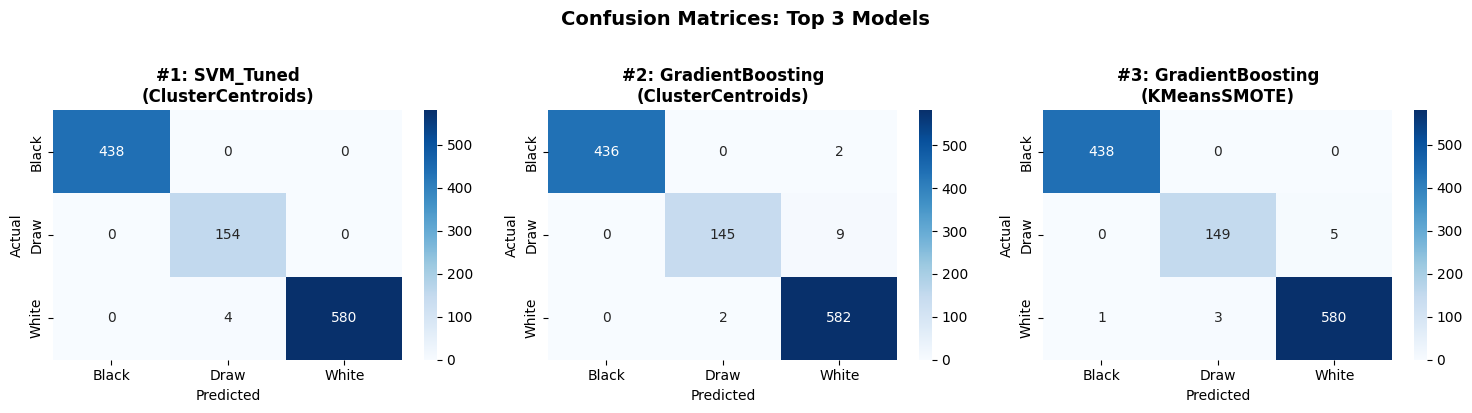

In [177]:
# Confusion matrices for top 3 models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
class_names = ['Black', 'Draw', 'White']

for idx, (_, row) in enumerate(top3.iterrows()):
    y_pred = get_model_predictions(row, tuned_models, X_test_np, y_test_np)
    if y_pred is not None:
        cm = confusion_matrix(y_test_np, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=class_names, yticklabels=class_names)
        axes[idx].set_title(f"#{idx+1}: {row['Model']}\n({row['Resampling']})", fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    else:
        axes[idx].text(0.5, 0.5, f"Model not available\n{row['Model']}", 
                       ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"#{idx+1}: {row['Model']}")

plt.suptitle('Confusion Matrices: Top 3 Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_top3.png', dpi=100, bbox_inches='tight')
plt.show()

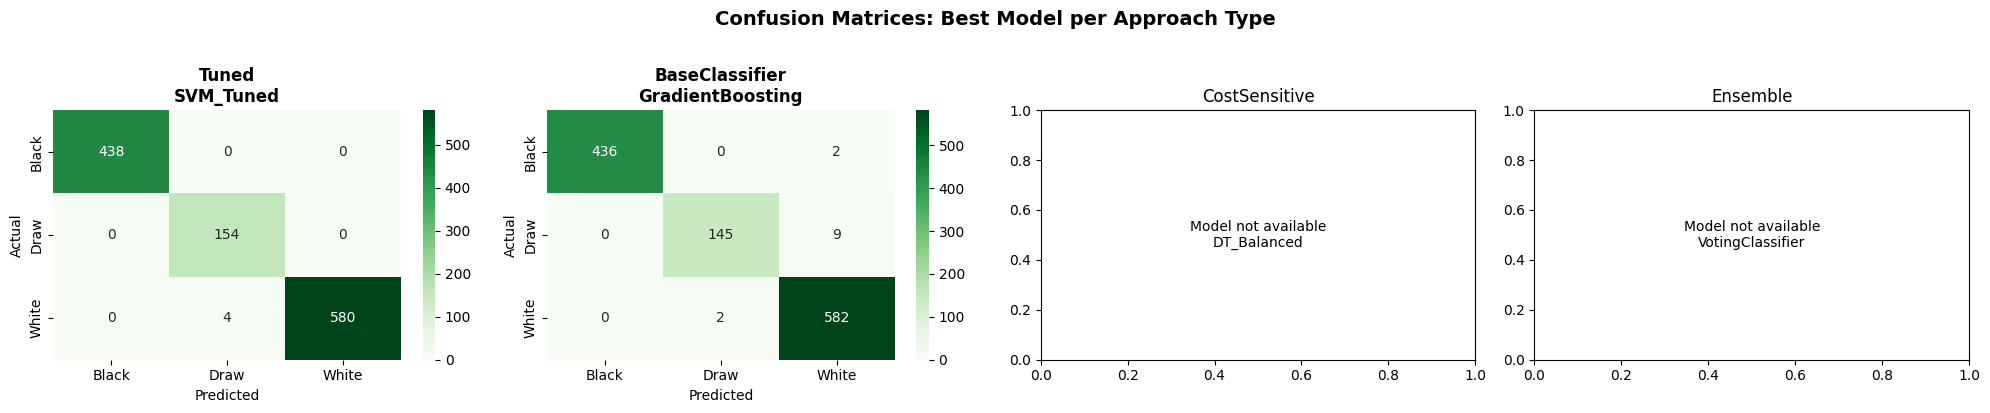

In [178]:
# Confusion matrices for best model per type
n_types = len(best_per_type)
fig, axes = plt.subplots(1, n_types, figsize=(5*n_types, 4))
if n_types == 1:
    axes = [axes]

for idx, (_, row) in enumerate(best_per_type.iterrows()):
    y_pred = get_model_predictions(row, tuned_models, X_test_np, y_test_np)
    if y_pred is not None:
        cm = confusion_matrix(y_test_np, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx],
                    xticklabels=class_names, yticklabels=class_names)
        axes[idx].set_title(f"{row['Type']}\n{row['Model']}", fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    else:
        axes[idx].text(0.5, 0.5, f"Model not available\n{row['Model']}", 
                       ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"{row['Type']}")

plt.suptitle('Confusion Matrices: Best Model per Approach Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_best_per_type.png', dpi=100, bbox_inches='tight')
plt.show()

In [180]:
# Confusion matrix analysis for best overall model
best_overall = top3.iloc[0]
y_pred_best = get_model_predictions(best_overall, tuned_models, X_test_np, y_test_np)

if y_pred_best is not None:
    cm = confusion_matrix(y_test_np, y_pred_best)
    
    # Per-class metrics with zero division handling
    per_class_acc = cm.diagonal() / np.where(cm.sum(axis=1) == 0, 1, cm.sum(axis=1))
    per_class_prec = cm.diagonal() / np.where(cm.sum(axis=0) == 0, 1, cm.sum(axis=0))
    
    analysis_df = pd.DataFrame({
        'Class': class_names,
        'Support': cm.sum(axis=1),
        'Correct': cm.diagonal(),
        'Accuracy': per_class_acc,
        'Precision': per_class_prec
    })

In [181]:
# Overall Winner
winner = united_nations.nlargest(1, 'F1_Macro').iloc[0]
winner_df = pd.DataFrame([{
    'Model': winner['Model'],
    'Type': winner['Type'],
    'Resampling': winner['Resampling'],
    'Accuracy': f"{winner['Accuracy']:.4f}",
    'F1_Macro': f"{winner['F1_Macro']:.4f}"
}])
winner_df.style.set_caption('OVERALL WINNER').set_properties(**{'font-weight': 'bold'})

,Model,Type,Resampling,Accuracy,F1_Macro
0,SVM_Tuned,Tuned,ClusterCentroids,0.9966,0.9946


## Step 10: Bias-Variance Analysis

Bias-variance decomposition helps understand model behavior:
- High bias: model is too simple, underfitting
- High variance: model is too complex, overfitting

We estimate these using cross-validation scores.

In [182]:
# Calculate bias-variance estimates using cross-validation
# Use X_np and y_np from the resampled_data (baseline without resampling)
X_train_for_bv, y_train_for_bv = resampled_data.get('None', (X_np, y_np))

bias_variance_results = []

# Models to analyze for bias-variance
models_for_bv = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'LogisticRegression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100),
    'SVM': SVC(random_state=RANDOM_SEED, kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

scaler_bv = StandardScaler()
X_train_bv = scaler_bv.fit_transform(X_train_for_bv)

for model_name, model in models_for_bv.items():
    cv_scores = cross_val_score(model, X_train_bv, y_train_for_bv, cv=5, scoring='accuracy')
    
    # Fit on full training set
    model.fit(X_train_bv, y_train_for_bv)
    train_acc = model.score(X_train_bv, y_train_for_bv)
    test_acc = model.score(scaler_bv.transform(X_test_np), y_test_np)
    
    # Bias estimate: 1 - mean CV score (error)
    # Variance estimate: std of CV scores
    bias_estimate = 1 - cv_scores.mean()
    variance_estimate = cv_scores.std()
    
    bias_variance_results.append({
        'Model': model_name,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Bias_Estimate': bias_estimate,
        'Variance_Estimate': variance_estimate,
        'Overfit_Gap': train_acc - test_acc
    })

bias_variance_df = pd.DataFrame(bias_variance_results)

In [183]:
# Display bias-variance results
bias_variance_df.sort_values('Test_Accuracy', ascending=False).round(4)

,Model,Train_Accuracy,Test_Accuracy,CV_Mean,CV_Std,Bias_Estimate,Variance_Estimate,Overfit_Gap
0,DecisionTree,0.9981,0.9906,0.9915,0.0018,0.0085,0.0018,0.0074
3,GradientBoosting,0.9955,0.9906,0.9887,0.0011,0.0113,0.0011,0.0049
2,RandomForest,0.9981,0.9889,0.9930,0.0021,0.0070,0.0021,0.0091
5,KNN,0.9909,0.9881,0.9830,0.0020,0.0170,0.0020,0.0028
4,SVM,0.9881,0.9864,0.9847,0.0020,0.0153,0.0020,0.0017
1,LogisticRegression,0.8746,0.8631,0.8716,0.0119,0.1284,0.0119,0.0115


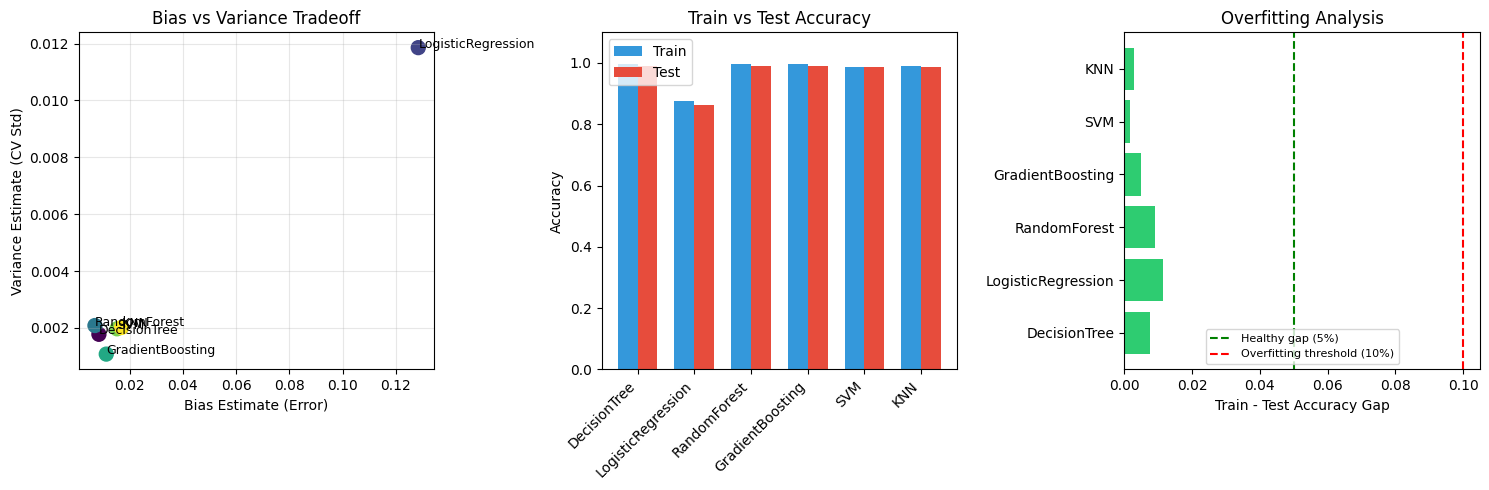

In [184]:
# Visualize bias-variance tradeoff
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Bias vs Variance scatter
axes[0].scatter(bias_variance_df['Bias_Estimate'], bias_variance_df['Variance_Estimate'], 
                s=100, c=range(len(bias_variance_df)), cmap='viridis')
for i, row in bias_variance_df.iterrows():
    axes[0].annotate(row['Model'], (row['Bias_Estimate'], row['Variance_Estimate']), 
                     fontsize=9, ha='left')
axes[0].set_xlabel('Bias Estimate (Error)')
axes[0].set_ylabel('Variance Estimate (CV Std)')
axes[0].set_title('Bias vs Variance Tradeoff')
axes[0].grid(True, alpha=0.3)

# Plot 2: Train vs Test accuracy
x = range(len(bias_variance_df))
width = 0.35
axes[1].bar([i - width/2 for i in x], bias_variance_df['Train_Accuracy'], width, label='Train', color='#3498db')
axes[1].bar([i + width/2 for i in x], bias_variance_df['Test_Accuracy'], width, label='Test', color='#e74c3c')
axes[1].set_xticks(x)
axes[1].set_xticklabels(bias_variance_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train vs Test Accuracy')
axes[1].legend()
axes[1].set_ylim(0, 1.1)

# Plot 3: Overfitting gap
colors = ['#2ecc71' if gap < 0.05 else '#e74c3c' if gap > 0.1 else '#f39c12' 
          for gap in bias_variance_df['Overfit_Gap']]
axes[2].barh(bias_variance_df['Model'], bias_variance_df['Overfit_Gap'], color=colors)
axes[2].axvline(x=0.05, color='green', linestyle='--', label='Healthy gap (5%)')
axes[2].axvline(x=0.1, color='red', linestyle='--', label='Overfitting threshold (10%)')
axes[2].set_xlabel('Train - Test Accuracy Gap')
axes[2].set_title('Overfitting Analysis')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.savefig('bias_variance_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

### Bias-Variance Interpretation

- **High Bias (Underfitting)**: Models with high bias estimate have poor performance on both train and test sets
- **High Variance (Overfitting)**: Models with high CV std or large train-test gap are overfitting
- **Green bars**: Healthy overfitting gap (<5%)
- **Yellow bars**: Moderate overfitting (5-10%)
- **Red bars**: Severe overfitting (>10%)

Decision trees typically have high variance (overfit), while logistic regression has higher bias (simpler model).
Ensemble methods like Random Forest and Gradient Boosting often achieve a good balance.

In [185]:
# Log final results to MLflow
mlflow.end_run()  # End any active run first
with mlflow.start_run(run_name='FINAL_COMPARISON'):
    for rank, (_, row) in enumerate(top3.iterrows(), 1):
        mlflow.log_param(f'top{rank}_model', row['Model'])
        mlflow.log_param(f'top{rank}_type', row['Type'])
        mlflow.log_param(f'top{rank}_resampling', row['Resampling'])
        mlflow.log_metric(f'top{rank}_f1', row['F1_Macro'])
        mlflow.log_metric(f'top{rank}_accuracy', row['Accuracy'])
    mlflow.log_param('winner_model', winner['Model'])
    mlflow.log_param('winner_type', winner['Type'])
    mlflow.log_param('winner_resampling', winner['Resampling'])
    mlflow.log_metric('winner_f1', winner['F1_Macro'])
    mlflow.log_metric('winner_accuracy', winner['Accuracy'])
    mlflow.log_artifact('base_classifiers_comparison.png')
    if os.path.exists('ensemble_comparison.png'):
        mlflow.log_artifact('ensemble_comparison.png')
    mlflow.log_artifact('resampling_techniques_comparison.png')
    mlflow.log_artifact('best_per_type_comparison.png')
    mlflow.log_artifact('top3_models.png')
    if os.path.exists('confusion_matrices_top3.png'):
        mlflow.log_artifact('confusion_matrices_top3.png')
    if os.path.exists('confusion_matrices_best_per_type.png'):
        mlflow.log_artifact('confusion_matrices_best_per_type.png')
    if os.path.exists('bias_variance_analysis.png'):
        mlflow.log_artifact('bias_variance_analysis.png')
    united_nations.to_csv('unified_results.csv', index=False)
    mlflow.log_artifact('unified_results.csv')

pd.DataFrame([{'Status': 'DONE', 'Message': 'All results logged to MLflow'}])

,Status,Message
0,DONE,All results logged to MLflow


base_classifiers_comparison.png       learning_curves.png
bell/                                 mlflow.db
best_per_type_comparison.png          mlruns/
bias_variance_analysis.png            requirements.txt
confusion_matrices_best_per_type.png  resampling_techniques_comparison.png
confusion_matrices_top3.png           top3_models.png
ensemble_comparison.png               unified_results.csv


In [46]:
# Run MLflow UI to view experiments
# Navigate to http://127.0.0.1:5000 in your browser
!mlflow ui --backend-store-uri file:./mlruns --port 5000 --host 127.0.0.1

Backend store URI not provided. Using sqlite:///mlflow.db
Registry store URI not provided. Using backend store URI.
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Updating database tables
2025/12/20 13:17:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Updating database tables
2025/12/20 13:17:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
[MLflow] Security middleware enabled with default settings (loca

: 

: 